In [ ]:
# !pip install tensorflow==2.1.0

In [ ]:
import pandas as pd
import os.path
import pickle 
import numpy as np
import keras.utils
import time
from keras.callbacks import TensorBoard, CSVLogger
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense,Flatten,LSTM,Conv1D,GlobalMaxPool1D,Dropout,Bidirectional
from tensorflow.keras.layers import Embedding
from keras import optimizers
from keras.layers import Input
from keras.models import Model
from keras.utils.vis_utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import load_model
from nltk.corpus import stopwords
import operator

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#spacy is for nlp 
# !python -m spacy download en_core_web_sm
!pip install spacy==3.4.1
import spacy
# !python -m spacy download en
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

In [ ]:
pd.options.display.max_rows
pd.set_option('display.max_colwidth', None)

In [ ]:
#it is an interface to Graphviz,
#can parse and dump into the DOT language used by GraphViz,
!pip install pydot==1.2.3


In [ ]:
from google.colab import drive
drive.mount("/content/drive/")
import os
os.chdir('/content/drive/My Drive/Liar')

Mounted at /content/drive/


In [ ]:
train_data = pd.read_table('train.tsv', names = ["id", "label", "statement", "subject", "speaker", "job", "state", "party",
                                            "barely-true", "false", "half-true", "mostly-true", "pants-fire", "venue"])

val_data = pd.read_table('valid.tsv', names = ["id", "label", "statement", "subject", "speaker", "job", "state", "party",
                                            "barely-true", "false", "half-true", "mostly-true", "pants-fire", "venue"])

test_data = pd.read_table('test.tsv', names = ["id", "label", "statement", "subject", "speaker", "job", "state", "party",
                                            "barely-true", "false", "half-true", "mostly-true", "pants-fire", "venue"])

In [ ]:
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)
print(train_data.label.unique())
train_data.head()

(10240, 14)
(1284, 14)
(1267, 14)
['false' 'half-true' 'mostly-true' 'true' 'barely-true' 'pants-fire']


,id,label,statement,subject,speaker,job,state,party,barely-true,false,half-true,mostly-true,pants-fire,venue
0,2635.json,false,Says the Annies List political group supports third-trimester abortions on demand.,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by voting to give George Bush the benefit of the doubt on Iran.""",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to mandate free sex change surgeries.,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of my term.,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [ ]:
print(train_data.info())
print(val_data.info())
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           10240 non-null  object 
 1   label        10240 non-null  object 
 2   statement    10240 non-null  object 
 3   subject      10238 non-null  object 
 4   speaker      10238 non-null  object 
 5   job          7343 non-null   object 
 6   state        8032 non-null   object 
 7   party        10238 non-null  object 
 8   barely-true  10238 non-null  float64
 9   false        10238 non-null  float64
 10  half-true    10238 non-null  float64
 11  mostly-true  10238 non-null  float64
 12  pants-fire   10238 non-null  float64
 13  venue        10138 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1284 entries, 0 to 1283
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------   

In [ ]:
#Output labeling like pants-fire to 0 and ...
y_label_dict = {"pants-fire" : 0, "false" : 1, "barely-true" : 2, "half-true" : 3, "mostly-true" : 4, "true" : 5}
print(y_label_dict)

train_data['output'] = train_data['label'].apply(lambda x: y_label_dict[x])
val_data['output'] = val_data['label'].apply(lambda x: y_label_dict[x])
test_data['output'] = test_data['label'].apply(lambda x: y_label_dict[x])

num_classes = 6



{'pants-fire': 0, 'false': 1, 'barely-true': 2, 'half-true': 3, 'mostly-true': 4, 'true': 5}


In [ ]:
# Now we will take top frequent meta data and then we'll make new feature for thier ids.
# suppose we have a most frequent speaker barak obama than we'll give him a id 1 and so on. And for other non frequent speakers we'll give 15 to them

Top Frequent **Speakers**

In [ ]:
#frequent_speakers = train_data['speaker'].value_counts()[:20].reset_index().to_dict()['index']
#frequent_speakers = dict((v,k) for k,v in frequent_speakers.iteritems())
frequent_speakers = {'barack-obama' : 0, 'donald-trump' : 1, 'hillary-clinton' : 2, 
                     'mitt-romney' : 3, 'scott-walker' : 4, 'john-mccain' : 5, 
                     'rick-perry' : 6, 'chain-email' : 7, 'marco-rubio' : 8, 'viral-image':13,
                     'rick-scott' : 9, 'ted-cruz' : 10, 'bernie-s' : 11, 'newt-gingrich':16,
                     'chris-christie' : 12, 'facebook-posts' : 13,'blog-posting':13, 
                     'charlie-crist' : 14, 'congressional' : 15, 'republican' : 15, 
                     'national-committe' : 15, 'democratic':15}

print(frequent_speakers)

def get_speaker_id(speaker):
  if isinstance(speaker, str):
    matched = [sp for sp in frequent_speakers if sp in speaker.lower() ]
    if len(matched)>0:
      return frequent_speakers[matched[0]]
    else:
      return len(set(frequent_speakers.values())) 
  else:
    return len(set(frequent_speakers.values())) 
  

train_data['speaker_id'] = train_data['speaker'].apply(get_speaker_id)
val_data['speaker_id'] = val_data['speaker'].apply(get_speaker_id)
test_data['speaker_id'] = test_data['speaker'].apply(get_speaker_id)

print(len(set(frequent_speakers.values()))) 

train_data['speaker_id'].value_counts()

{'barack-obama': 0, 'donald-trump': 1, 'hillary-clinton': 2, 'mitt-romney': 3, 'scott-walker': 4, 'john-mccain': 5, 'rick-perry': 6, 'chain-email': 7, 'marco-rubio': 8, 'viral-image': 13, 'rick-scott': 9, 'ted-cruz': 10, 'bernie-s': 11, 'newt-gingrich': 16, 'chris-christie': 12, 'facebook-posts': 13, 'blog-posting': 13, 'charlie-crist': 14, 'congressional': 15, 'republican': 15, 'national-committe': 15, 'democratic': 15}
17


17    7348
0      488
15     347
1      275
2      239
3      176
13     156
4      149
5      148
7      142
6      142
8      117
9      115
10      93
11      88
12      78
14      70
16      69
Name: speaker_id, dtype: int64

Top frequent **Job** **Titles**

In [ ]:
#frequent_jobs = train_data['job'].str.lower().value_counts()[:20].reset_index().to_dict()['index']
#frequent_jobs = dict((v,k) for k,v in frequent_jobs.iteritems())
frequent_jobs = { 'senator' : 0, 'president' : 1, 'governor' : 2, 
                 'u.s. representative' : 3, 'attorney' : 4, 'congressman' : 5, 
                 'congresswoman' : 5, 'social media posting' : 6, 'lawyer' : 4, 
                 'businessman' : 6,  'radio host' : 8, 'host':8,
                  'mayor' : 7, 'assembly' : 9,'representative' : 3, 
                 'senate' : 9,'state representative' : 10,'milwaukee county executive' : 11,
                 'u.s. house of representatives' : 3,'house representative' : 3,
                 'house of representatives' : 3,'house member':3}


print(frequent_jobs)

def get_job_id(job):
  if isinstance(job, str):
    matched = [jb for jb in frequent_jobs if jb in job.lower() ]
    if len(matched)>0:
      return frequent_jobs[matched[0]]
    else:
      return len(set(frequent_jobs.values()))
  else:
    return len(set(frequent_jobs.values()))
  

train_data['job_id'] = train_data['job'].apply(get_job_id)
val_data['job_id'] = val_data['job'].apply(get_job_id)
test_data['job_id'] = test_data['job'].apply(get_job_id)

print(len(set(frequent_jobs.values())))

train_data['job_id'].value_counts()

{'senator': 0, 'president': 1, 'governor': 2, 'u.s. representative': 3, 'attorney': 4, 'congressman': 5, 'congresswoman': 5, 'social media posting': 6, 'lawyer': 4, 'businessman': 6, 'radio host': 8, 'host': 8, 'mayor': 7, 'assembly': 9, 'representative': 3, 'senate': 9, 'state representative': 10, 'milwaukee county executive': 11, 'u.s. house of representatives': 3, 'house representative': 3, 'house of representatives': 3, 'house member': 3}
12


12    4597
1     1212
0     1201
3      911
2      892
8      279
9      253
5      232
4      223
7      167
11     149
6      124
Name: job_id, dtype: int64

top frequent **Party**

In [ ]:
# frequent_parties = train_data['party'].str.lower().value_counts()[:5].reset_index().to_dict()['index']
# frequent_parties = dict((v,k) for k,v in frequent_parties.iteritems())
frequent_parties = {'organization': 3, 'none': 2, 'republican': 0, 'democrat': 1, 'independent': 4}

print(frequent_parties)
#frequent_parties['columnist']=frequent_parties['journalist']
#frequent_parties['talk-show-host']=frequent_parties['journalist']
def get_party_id(party):
  if isinstance(party, str):
    matched = [pt for pt in frequent_parties if pt in party.lower() ]
    if len(matched)>0:
      return frequent_parties[matched[0]]
    else:
      return len(set(frequent_parties.values())) 
  else:
    return len(set(frequent_parties.values())) 
  

train_data['party_id'] = train_data['party'].apply(get_party_id)
val_data['party_id'] = val_data['party'].apply(get_party_id)
test_data['party_id'] = test_data['party'].apply(get_party_id)

print(len(set(frequent_parties.values()))) 

train_data['party_id'].value_counts()


{'organization': 3, 'none': 2, 'republican': 0, 'democrat': 1, 'independent': 4}
5


0    4497
1    3337
2    1744
5     296
3     219
4     147
Name: party_id, dtype: int64

top frequent **States**

In [ ]:
#states_50 = ['Alabama','Alaska','Arizona','Arkansas','California',
#                   'Colorado', 'Connecticut','Delaware','Florida', 'Georgia',
#                   'Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas',
#                   'Kentucky','Louisiana','Maine','Maryland','Massachusetts',
#                   'Michigan','Minnesota','Mississippi', 'Missouri','Montana',
#                   'Nebraska','Nevada','New Hampshire','New Jersey','New Mexico',
#                   'New York','North Carolina','North Dakota','Ohio','Oklahoma',
#                   'Oregon','Pennsylvania','Rhode Island','South Carolina',
#                   'South Dakota','Tennessee','Texas','Utah','Vermont','Virginia',
#                   'Washington','West Virginia','Wisconsin','Wyoming']

# frequent_states = dict((v.lower(),k) for k,v in enumerate(states_50))

other_states = ['wyoming', 'colorado', 'hawaii', 'tennessee', 'nevada', 'maine',
                'north dakota', 'mississippi', 'south dakota', 'oklahoma', 
                'delaware', 'minnesota', 'north carolina', 'arkansas', 'indiana', 
                'maryland', 'louisiana', 'idaho', 'iowa', 'west virginia', 
                'michigan', 'kansas', 'utah', 'connecticut', 'montana', 'vermont', 
                'pennsylvania', 'alaska', 'kentucky', 'nebraska', 'new hampshire', 
                'missouri', 'south carolina', 'alabama', 'new mexico']


frequent_states = {'texas': 1, 'florida': 2, 'wisconsin': 3, 'new york': 4, 
                    'illinois': 5, 'ohio': 6, 'georgia': 7, 'virginia': 8, 
                   'rhode island': 9, 'oregon': 10, 'new jersey': 11, 
                   'massachusetts': 12, 'arizona': 13, 'california': 14, 
                   'washington': 15}
for state in other_states:
  frequent_states[state]=0

print(frequent_states)

def get_state_id(state):
    if isinstance(state, str):
        if state.lower().rstrip() in frequent_states:
            return frequent_states[state.lower().rstrip()]
        else:
            if 'washington' in state.lower():
                return frequent_states['washington']
            else:
                return len(set(frequent_states.values()))
    else:
        return len(set(frequent_states.values()))


train_data['state_id'] = train_data['state'].apply(get_state_id)
val_data['state_id'] = val_data['state'].apply(get_state_id)
test_data['state_id'] = test_data['state'].apply(get_state_id)

print(len(set(frequent_states.values())))

train_data['state_id'].value_counts()

{'texas': 1, 'florida': 2, 'wisconsin': 3, 'new york': 4, 'illinois': 5, 'ohio': 6, 'georgia': 7, 'virginia': 8, 'rhode island': 9, 'oregon': 10, 'new jersey': 11, 'massachusetts': 12, 'arizona': 13, 'california': 14, 'washington': 15, 'wyoming': 0, 'colorado': 0, 'hawaii': 0, 'tennessee': 0, 'nevada': 0, 'maine': 0, 'north dakota': 0, 'mississippi': 0, 'south dakota': 0, 'oklahoma': 0, 'delaware': 0, 'minnesota': 0, 'north carolina': 0, 'arkansas': 0, 'indiana': 0, 'maryland': 0, 'louisiana': 0, 'idaho': 0, 'iowa': 0, 'west virginia': 0, 'michigan': 0, 'kansas': 0, 'utah': 0, 'connecticut': 0, 'montana': 0, 'vermont': 0, 'pennsylvania': 0, 'alaska': 0, 'kentucky': 0, 'nebraska': 0, 'new hampshire': 0, 'missouri': 0, 'south carolina': 0, 'alabama': 0, 'new mexico': 0}
16


16    2238
0     1211
1     1009
2     1003
3      714
4      659
5      558
6      448
7      433
8      408
9      371
10     242
11     241
12     212
13     182
14     163
15     148
Name: state_id, dtype: int64

top frequent **subjects**

In [ ]:
# health-care               381
# taxes                     308
# immigration               253
# elections                 252
# education                 237
# candidates-biography      190
# economy                   137
# guns                      130
# economy,jobs              125
# federal-budget            121
# jobs                       98
# energy                     94
# abortion                   92
# foreign-policy             85
# state-budget               75
# education,state-budget     69
# transportation             64
# crime                      59
# ethics                     58
# iraq                       55
# campaign-finance           53
# terrorism                  53
# environment                52
# history                    45
# job-accomplishments        45

frequent_subjects = {'health': 0, 'tax': 1, 'immigration': 2, 'election': 3, 
                     'education': 4, 'candidates-biography': 5, 'economy': 6, 
                     'gun': 7, 'job': 8, 'federal-budget': 6, 'energy': 9, 
                     'abortion': 10, 'foreign-policy': 6, 'state-budget': 6, 
                     'crime': 11, 'gays-and-lesbians' : 12, 'medicare' : 0, 
                     'terrorism' : 11, 'finance' : 6, 'criminal':11,
                     'transportation':13}

print(frequent_subjects)


def get_subject_id(subject):
  if isinstance(subject, str):
    matched = [sbj for sbj in frequent_subjects if sbj in subject.lower() ]
    if len(matched)>0:
      return frequent_subjects[matched[0]]
    else:
      return len(set(frequent_subjects.values())) 
  else:
    return len(set(frequent_subjects.values()))
  

train_data['subject_id'] = train_data['subject'].apply(get_subject_id)
val_data['subject_id'] = val_data['subject'].apply(get_subject_id)
test_data['subject_id'] = test_data['subject'].apply(get_subject_id)

print(len(set(frequent_subjects.values())))

train_data['subject_id'].value_counts()

{'health': 0, 'tax': 1, 'immigration': 2, 'election': 3, 'education': 4, 'candidates-biography': 5, 'economy': 6, 'gun': 7, 'job': 8, 'federal-budget': 6, 'energy': 9, 'abortion': 10, 'foreign-policy': 6, 'state-budget': 6, 'crime': 11, 'gays-and-lesbians': 12, 'medicare': 0, 'terrorism': 11, 'finance': 6, 'criminal': 11, 'transportation': 13}
14


6     2103
14    1909
0     1302
1      906
4      621
3      569
5      512
2      506
11     438
8      409
9      305
7      278
10     170
13     127
12      85
Name: subject_id, dtype: int64

top frequent **Venues**

In [ ]:
frequent_venues = {'news release' : 0, 'interview' : 1, 'press release' : 2, 
                   'speech' : 3, 'tv' : 4, 'tweet' : 5, 'campaign' : 6, 
                   'television' : 4, 'debate' : 7, 'news conference' : 8, 
                   'facebook' : 5, 'press conference' : 8, 'radio' : 9, 
                   'e-mail' : 10, 'email' : 10, 'mail' : 10, 'social media' : 5,
                   'twitter' : 5, 'blog':11, 'article':11,'comment':12, 'web':11}

print(frequent_venues)


def get_venue_id(venue):
  if isinstance(venue, str):
    matched = [ven for ven in frequent_venues if ven in venue.lower() ]
    if len(matched)>0:
      return frequent_venues[matched[0]]
    else:
      return len(set(frequent_venues.values())) 
  else:
    return len(set(frequent_venues.values()))
  

train_data['venue_id'] = train_data['venue'].apply(get_venue_id)
val_data['venue_id'] = val_data['venue'].apply(get_venue_id)
test_data['venue_id'] = test_data['venue'].apply(get_venue_id)

print(len(set(frequent_venues.values())))

train_data['venue_id'].value_counts()

{'news release': 0, 'interview': 1, 'press release': 2, 'speech': 3, 'tv': 4, 'tweet': 5, 'campaign': 6, 'television': 4, 'debate': 7, 'news conference': 8, 'facebook': 5, 'press conference': 8, 'radio': 9, 'e-mail': 10, 'email': 10, 'mail': 10, 'social media': 5, 'twitter': 5, 'blog': 11, 'article': 11, 'comment': 12, 'web': 11}
13


13    2695
1     1752
3     1059
7      735
6      679
4      568
11     529
5      473
10     356
2      346
12     337
0      324
8      249
9      138
Name: venue_id, dtype: int64

Encoding of the **statement**

In [ ]:
def load_statement_vocab_dict(train_data):
  vocabulary_dict = {}
  #checking if pickle file already exists
  if not os.path.exists('vocabulary.p'):
    #tokenisation is to segregate a text into small chuncks. Like "Let's complete the task" to "let's","complete","the","task".
    #fit_on_texts method is a part of Keras tokenizer class which is used to update the internal vocabulary for the texts list
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_data['statement'])

    #In this dictionary, we have unique integers assigned to each word.
    vocabulary_dict = tokenizer.word_index
    print(len(vocabulary_dict))
    pickle.dump(vocabulary_dict, open( "vocabulary.p", "wb" ))
    print('Created Vocabulary Dictionary...')
    print('Saved Vocabulary Dictionary...')
  else:
    print('Loading Vocabulary Dictionary...')
    vocabulary_dict = pickle.load(open("vocabulary.p", "rb" ))
  return vocabulary_dict

#preprocessing excluding stopwords. Then making a word id feature to store ids of words of statement in form of vectors
#like "stock market crashed" -> [302 488 989]

def preprocess_statement(statement):
  statement = [w for w in statement.split(' ') if w not in stopwords.words('english')]
  statement = ' '.join(statement)

  #converting sentence into list of individual list of word
  text = text_to_word_sequence(statement)
  val = [0] * 10
  val = [vocabulary_dict[t] for t in text if t in vocabulary_dict] 
  return val



vocabulary_dict = load_statement_vocab_dict(train_data)
train_data['word_id'] = train_data['statement'].apply(preprocess_statement)
val_data['word_id'] = val_data['statement'].apply(preprocess_statement)
test_data['word_id'] = test_data['statement'].apply(preprocess_statement)


Loading Vocabulary Dictionary...


POS tags

In [ ]:
pos_dict = {'NOUN' : 0, 'VERB' : 1, 'ADP' : 2, 'PROPN' : 3, 'PUNCT' : 4, 
            'DET' : 5, 'ADJ' : 6, 'NUM' : 7, 'ADV' : 8, 'PRON' : 9, 'X' : 9, 
            'PART' : 9, 'SYM' : 9, 'INTJ' : 9 }

def get_pos(statement):
  doc = nlp(statement)
  taglist = []
  for token in doc:
    #token.pos_ => give us the pos of the particular word
    #then we are taking the id of that pos from pos_dict
    taglist.append(pos_dict.get(token.pos_,max(pos_dict.values())))
  return taglist
train_data['pos_id'] = train_data['statement'].apply(get_pos)
val_data['pos_id'] = val_data['statement'].apply(get_pos)
test_data['pos_id'] = test_data['statement'].apply(get_pos)



DEP parse


In [ ]:
dep_dict = {'punct' : 0, 'prep' : 1, 'pobj' : 2, 'compound' : 3, 'det' : 4, 
            'nsubj' : 5, 'ROOT' : 6, 'amod' : 7, 'dobj' : 8, 'aux' : 9, 
            'advmod' : 10, 'nummod' : 10, 'ccomp' : 10, 'conj' : 10, 'cc' : 10, 
            'advcl' : 10, 'poss' : 10, 'mark' : 10, 'quantmod' : 10, 'relcl' : 10, 
            'attr' : 10, 'xcomp' : 10, 'npadvmod' : 10, 'nmod' : 10, 'auxpass' : 10, 
            'acl' : 10, 'nsubjpass' : 10, 'pcomp' : 10, 'acomp' : 10, 'neg' : 10, 
            'appos' : 10, 'prt' : 10, '' : 10, 'expl' : 10, 'dative' : 10, 
            'agent' : 10, 'case' : 10, 'oprd' : 10, 'csubj' : 10, 'dep' : 10, 
            'intj' : 10, 'predet' : 10, 'parataxis' : 10, 'preconj' : 10, 
            'meta' : 10, 'csubjpass' : 10}


def get_dep_parse(statement):
  doc = nlp(statement)
  deplist = []
  for token in doc:
    deplist.append(dep_dict.get(token.dep_, max(dep_dict.values())))
  return deplist


train_data['dep_id'] = train_data['statement'].apply(get_dep_parse)
val_data['dep_id'] = val_data['statement'].apply(get_dep_parse)
test_data['dep_id'] = test_data['statement'].apply(get_dep_parse)

In [ ]:
train_data

,id,label,statement,subject,speaker,job,state,party,barely-true,false,...,output,speaker_id,job_id,party_id,state_id,subject_id,venue_id,word_id,pos_id,dep_id
0,2635.json,false,Says the Annies List political group supports third-trimester abortions on demand.,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,...,1,17,3,0,1,10,10,"[7, 6968, 1141, 520, 621, 385, 444, 5119, 585, 1601]","[1, 5, 3, 3, 6, 0, 1, 6, 4, 0, 0, 2, 0, 4]","[6, 4, 10, 10, 7, 5, 10, 7, 0, 3, 8, 1, 2, 0]"
1,10540.json,half-true,When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,...,3,17,12,1,8,8,3,"[63, 2091, 964, 866, 23, 602, 1142, 315, 180, 602, 1959, 34, 310, 560, 1365, 177]","[9, 9, 5, 0, 2, 0, 0, 4, 9, 1, 9, 6, 0, 1, 2, 9, 1, 9, 1, 2, 4, 3, 3, 3, 4, 3, 0, 4]","[10, 9, 4, 6, 1, 3, 2, 0, 5, 6, 10, 7, 5, 10, 10, 5, 10, 9, 10, 1, 0, 3, 10, 10, 0, 3, 6, 0]"
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by voting to give George Bush the benefit of the doubt on Iran.""",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,...,4,0,1,1,5,6,13,"[127, 101, 3546, 191, 254, 20, 329, 343, 310, 166, 1093, 3547, 416]","[3, 3, 1, 2, 3, 3, 4, 2, 1, 9, 1, 3, 3, 5, 0, 2, 5, 0, 2, 3, 4, 4]","[3, 5, 6, 1, 3, 2, 0, 1, 10, 9, 10, 3, 10, 4, 8, 1, 4, 2, 1, 2, 0, 0]"
3,1123.json,false,Health care reform legislation is likely to mandate free sex change surgeries.,health-care,blog-posting,NaN,NaN,none,7.0,19.0,...,1,13,12,2,16,0,0,"[32, 43, 266, 298, 666, 667, 404, 467, 417, 4148]","[0, 0, 0, 0, 9, 6, 9, 1, 6, 0, 0, 0, 4]","[3, 3, 3, 5, 6, 10, 9, 10, 7, 3, 3, 8, 0]"
4,9028.json,half-true,The economic turnaround started at the end of my term.,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,...,3,14,12,1,2,6,1,"[1, 325, 4149, 602, 408, 505]","[5, 6, 0, 1, 2, 5, 0, 2, 9, 0, 4]","[4, 7, 5, 6, 1, 4, 2, 1, 10, 2, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,5473.json,mostly-true,There are a larger number of shark attacks in Florida than there are cases of voter fraud.,"animals,elections",aclu-florida,NaN,Florida,none,0.0,1.0,...,4,17,12,2,2,3,1,"[74, 1101, 216, 6643, 819, 118, 709, 490, 619]","[9, 1, 5, 6, 0, 2, 0, 0, 2, 3, 9, 9, 1, 0, 2, 0, 0, 4]","[10, 6, 4, 7, 10, 1, 3, 2, 1, 2, 10, 10, 10, 10, 1, 3, 2, 0]"
10236,3408.json,mostly-true,Democrats have now become the party of the [Atlanta] metro area and of blacks.,elections,alan-powell,NaN,Georgia,republican,0.0,0.0,...,4,17,12,0,7,3,1,"[190, 857, 274, 492, 1698, 1015, 1563]","[3, 9, 8, 1, 5, 0, 2, 5, 4, 3, 9, 3, 0, 9, 2, 0, 4]","[5, 9, 10, 6, 4, 10, 1, 4, 0, 10, 0, 3, 2, 10, 10, 2, 0]"
10237,3959.json,half-true,"Says an alternative to Social Security that operates in Galveston County, Texas, has meant that participants will retire with a whole lot more money than under Social Security.","retirement,social-security",herman-cain,NaN,Georgia,republican,4.0,11.0,...,3,17,12,0,7,14,7,"[7, 3056, 184, 131, 12407, 5034, 173, 67, 3428, 6915, 2340, 1347, 579, 100, 184, 131]","[1, 5, 0, 2, 3, 3, 9, 1, 2, 3, 3, 4, 3, 4, 9, 1, 9, 0, 9, 1, 2, 5, 6, 0, 6, 0, 2, 2, 3, 3, 4]","[6, 4, 5, 1, 3, 2, 5, 10, 1, 3, 2, 0, 10, 0, 9, 10, 10, 5, 9, 10, 1, 4, 7, 10, 7, 2, 1, 1, 3, 2, 0]"
10238,2253.json,false,On lifting the U.S. Cuban embargo and allowing travel to Cuba.,"florida,foreign-policy",jeff-greene,NaN,Florida,democrat,3.0,1.0,...,1,17,12,1,2,6,7,"[11, 5040, 55, 56, 3536, 3896, 984, 2415, 1676]","[2, 1, 5, 3, 6, 0, 9, 1, 0, 2, 3, 4]","[6, 10, 4, 8, 7, 8, 10, 10, 8, 1, 2, 0]"


In [ ]:
#word embeddings
embeddings = {}
with open("glove.6B.100d.txt") as file_object:
  for line in file_object:
    word_embed = line.split()
    word = word_embed[0]
    embed = np.array(word_embed[1:], dtype="float32")
    embeddings[word.lower()]= embed

EMBED_DIM = 100
print(str(len(embeddings))+" : Word Embeddings Found")
print(len(embeddings[word]), " : Embedding Dimension")

#now we are making embedding matrix of our vocabulary 
num_words = len(vocabulary_dict) + 1
embedding_matrix = np.zeros((num_words, EMBED_DIM))
for word, i in vocabulary_dict.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embeddings_index = None

pos_embeddings = np.identity(max(pos_dict.values()), dtype=int)
dep_embeddings = np.identity(max(dep_dict.values()), dtype=int)

400000 : Word Embeddings Found
100  : Embedding Dimension


In [ ]:
vocabulary_dict

{'the': 1,
 'in': 2,
 'of': 3,
 'to': 4,
 'a': 5,
 'and': 6,
 'says': 7,
 'for': 8,
 'that': 9,
 'is': 10,
 'on': 11,
 'has': 12,
 'have': 13,
 'percent': 14,
 'are': 15,
 'than': 16,
 'was': 17,
 'more': 18,
 'we': 19,
 'by': 20,
 'state': 21,
 'from': 22,
 'it': 23,
 'with': 24,
 '000': 25,
 'as': 26,
 'obama': 27,
 'tax': 28,
 'not': 29,
 'our': 30,
 'year': 31,
 'health': 32,
 'years': 33,
 'president': 34,
 'people': 35,
 'he': 36,
 'states': 37,
 'at': 38,
 'would': 39,
 'million': 40,
 'an': 41,
 'be': 42,
 'care': 43,
 'his': 44,
 'one': 45,
 'i': 46,
 'you': 47,
 'their': 48,
 'were': 49,
 'this': 50,
 'jobs': 51,
 'over': 52,
 'will': 53,
 'new': 54,
 'u': 55,
 's': 56,
 'been': 57,
 'they': 58,
 'or': 59,
 '1': 60,
 'who': 61,
 'about': 62,
 'when': 63,
 'billion': 64,
 'all': 65,
 'bill': 66,
 'texas': 67,
 'only': 68,
 'out': 69,
 'every': 70,
 'said': 71,
 'taxes': 72,
 'under': 73,
 'there': 74,
 'federal': 75,
 'no': 76,
 'voted': 77,
 'barack': 78,
 'since': 79,
 'up':

In [ ]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [ 0.085703  , -0.22201   ,  0.16569   , ..., -0.074273  ,
         0.75808001, -0.34243   ],
       ...,
       [ 0.28738001, -0.52851999,  0.11159   , ...,  0.16271999,
         0.1443    , -0.2692    ],
       [ 0.10203   ,  0.21351001, -0.36059999, ..., -0.64951998,
         0.95039999,  0.46402001],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

**Word2Vec**

In [ ]:
#Converting X to format acceptable by gensim, removing annd punctuation stopwords in the process
import nltk
nltk.download('punkt')
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in train_data["statement"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import gensim
#Dimension of vectors we are generating
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

In [ ]:
#size of vocab
len(w2v_model.wv.vocab)

12061

In [ ]:
#examples
w2v_model["california"]

<ipython-input-25-560a53e87901>:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  w2v_model["california"]


array([-0.25265357,  0.055605  ,  0.05197754,  0.05497435,  0.01260896,
        0.1647193 , -0.11191851, -0.05462511,  0.4229351 , -0.15357971,
       -0.06112763,  0.10398456,  0.1311334 , -0.29484287, -0.02250891,
        0.01441911,  0.1537318 , -0.04324964, -0.34572896,  0.05315018,
        0.15620333,  0.45794156, -0.04767663,  0.05925527,  0.14091492,
        0.38953695,  0.19030713,  0.028491  ,  0.17022635,  0.23409037,
       -0.05655503, -0.3117344 ,  0.1050555 ,  0.19707349,  0.05377474,
        0.00508529,  0.14170262,  0.12164426, -0.02442543, -0.18841705,
       -0.01117133, -0.1832621 ,  0.09468553,  0.21743882,  0.15426582,
       -0.0164404 , -0.14580503, -0.02856809,  0.4590819 ,  0.09278703,
        0.42284283, -0.20807932, -0.02982431,  0.11804264,  0.30002856,
        0.13585544,  0.1133408 ,  0.14798924,  0.02999782,  0.01938899,
       -0.05396325, -0.14820908, -0.02663992,  0.2586928 , -0.3284412 ,
        0.01056528, -0.29302186, -0.3261204 ,  0.04535353, -0.14

In [ ]:
#building a matrix of embbedings
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
      try:
        weight_matrix[i] = model[word]
      except:
        continue
    return weight_matrix

embedding_vectors = get_weight_matrix(w2v_model, vocabulary_dict)

<ipython-input-26-66e8ec4df3af>:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  weight_matrix[i] = model[word]


In [ ]:
# w2v_model.wv.most_similar("lakshay")

In [ ]:
embedding_vectors

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.01293087,  0.00203645,  0.00061878, ..., -0.0126811 ,
        -0.00243458,  0.00829534],
       [-0.00678601, -0.00168352,  0.00666268, ..., -0.01135048,
        -0.00081046,  0.01107285],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
#matrix using word2vec
len(embedding_vectors)

12409

In [ ]:
#matrix using glove
len(embedding_matrix)

12409

**FastText**

In [ ]:
from gensim.models import FastText
model_ted = FastText(X, size=100, window=5, min_count=1)

In [ ]:
model_ted.wv.most_similar("lakshay")

[('singapore', 0.9973613023757935),
 ('value', 0.997344970703125),
 ('britains', 0.9973307847976685),
 ('puerto', 0.9973288774490356),
 ('passage', 0.9973275661468506),
 ('kiss', 0.997324526309967),
 ('plastics', 0.9973223209381104),
 ('prosperity', 0.9973194599151611),
 ('sins', 0.9973175525665283),
 ('benefit', 0.9973174333572388)]

In [ ]:
len(model_ted.wv.vocab)

12061

In [ ]:
embedding_fasttext = get_weight_matrix(model_ted, vocabulary_dict)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
#matrix using FastText of facebook
len(embedding_fasttext)

12409

**Bert** **Encodings**

In [ ]:
!pip install transformers
!pip install pytorch-pretrained-bert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
%matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')



In [ ]:
## bert encoding is not completed yet. We'll continue it from here

**TF-IDF Encodings**

In [ ]:
text = train_data["statement"]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = list(text)
tfidf = TfidfVectorizer(max_features = 6000) 
tfidf.fit(corpus)
tfidf_features = tfidf.transform(corpus)
print(tfidf_features.shape)

(10240, 6000)


In [ ]:
tfidf.get_feature_names_out()[0:1000]

array(['00', '000', '05', '06', '09', '10', '100', '104', '105', '10th',
       '11', '110', '115', '12', '120', '125', '128', '13', '130', '135',
       '14', '140', '142', '144', '15', '150', '154', '155', '15th', '16',
       '160', '163', '168', '17', '175', '176', '18', '180', '1800s',
       '19', '190', '1917', '1920s', '1928', '1930s', '1940', '1947',
       '1950', '1950s', '1960', '1960s', '1968', '1970s', '1972', '1973',
       '1976', '1978', '1979', '1980', '1980s', '1981', '1982', '1984',
       '1985', '1986', '1990', '1990s', '1991', '1992', '1993', '1994',
       '1995', '1996', '1997', '1999', '1st', '20', '200', '2000', '2001',
       '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
       '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
       '20th', '21', '21st', '22', '220', '23', '24', '240', '25', '250',
       '25th', '26', '260', '27', '270', '275', '28', '29', '2nd', '30',
       '300', '30s', '31', '32', '320', '33', '34', '35'

In [ ]:
# print preview of IDF(t) values 
df_idf = pd.DataFrame(tfidf.idf_, index=tfidf.get_feature_names_out(),columns=["idf_weights"]) 
# sort ascending IDF(t) scores
# - recall that IDF(t) = N/DF(t), where N is the number of documents and DF(t) = number of times a term occurs across all documents
# - the rarer a word is, the higher the IDF(t) value
df_idf=df_idf.sort_values(by=['idf_weights'],ascending=False) 
df_idf.iloc[0:20,:]
df_idf

,idf_weights
philippine,9.541007
isil,9.541007
meth,9.541007
silberkraus,9.541007
ottumwa,9.541007
...,...
and,2.431945
to,2.063969
of,1.998529
in,1.929165


**Hyperparamter**

In [ ]:
vocab_length = len(vocabulary_dict.keys())
hidden_size = EMBED_DIM #Has to be same as EMBED_DIM
lstm_size = 100
num_steps = 15
num_epochs = 30
batch_size = 40


#Meta data related hyper params
num_party = len(train_data.party_id.unique())
num_state = len(train_data.state_id.unique())
num_venue = len(train_data.venue_id.unique())
num_job = len(train_data.job_id.unique())
num_sub = len(train_data.subject_id.unique())
num_speaker = len(train_data.speaker_id.unique())
print(num_party)
print(num_state)
print(num_venue)
print(num_job)
print(num_sub)
print(num_speaker)
print(train_data.columns)

6
17
14
12
15
18
Index(['id', 'label', 'statement', 'subject', 'speaker', 'job', 'state',
       'party', 'barely-true', 'false', 'half-true', 'mostly-true',
       'pants-fire', 'venue', 'output', 'speaker_id', 'job_id', 'party_id',
       'state_id', 'subject_id', 'venue_id', 'word_id', 'pos_id', 'dep_id'],
      dtype='object')


**Data Prep**

In [ ]:
from keras_preprocessing.sequence import pad_sequences

X_train = train_data['word_id']
X_val = val_data['word_id']
X_test = test_data['word_id']

Y_train = train_data['output']
Y_train = keras.utils.to_categorical(Y_train, num_classes=6)

Y_val = val_data['output']
Y_val = keras.utils.to_categorical(Y_val, num_classes=6)

X_train = pad_sequences(X_train, maxlen=num_steps, padding='post',truncating='post')
X_val = pad_sequences(X_val, maxlen=num_steps, padding='post',truncating='post')
X_test = pad_sequences(X_test, maxlen=num_steps, padding='post',truncating='post')

X_train_pos = train_data['pos_id']
X_val_pos = val_data['pos_id']
X_test_pos = test_data['pos_id']

X_train_pos = pad_sequences(X_train_pos, maxlen=num_steps, padding='post',truncating='post')
X_val_pos = pad_sequences(X_val_pos, maxlen=num_steps, padding='post',truncating='post')
X_test_pos = pad_sequences(X_test_pos, maxlen=num_steps, padding='post',truncating='post')


X_train_dep = train_data['dep_id']
X_val_dep = val_data['dep_id']
X_test_dep = test_data['dep_id']

X_train_dep = pad_sequences(X_train_dep, maxlen=num_steps, padding='post',truncating='post')
X_val_dep = pad_sequences(X_val_dep, maxlen=num_steps, padding='post',truncating='post')
X_test_dep = pad_sequences(X_test_dep, maxlen=num_steps, padding='post',truncating='post')

#Meta data preparation
party_train = keras.utils.to_categorical(train_data['party_id'], num_classes=num_party)
state_train = keras.utils.to_categorical(train_data['state_id'], num_classes=num_state)
venue_train = keras.utils.to_categorical(train_data['venue_id'], num_classes=num_venue)
job_train = keras.utils.to_categorical(train_data['job_id'], num_classes=num_job+1)
subject_train = keras.utils.to_categorical(train_data['subject_id'], num_classes=num_sub)
speaker_train = keras.utils.to_categorical(train_data['speaker_id'], num_classes=num_speaker)


X_train_meta = np.hstack((party_train, state_train, venue_train, job_train, subject_train, speaker_train))


party_val = keras.utils.to_categorical(val_data['party_id'], num_classes=num_party)
state_val = keras.utils.to_categorical(val_data['state_id'], num_classes=num_state)
venue_val = keras.utils.to_categorical(val_data['venue_id'], num_classes=num_venue)
job_val = keras.utils.to_categorical(val_data['job_id'], num_classes=num_job+1)
subject_val = keras.utils.to_categorical(val_data['subject_id'], num_classes=num_sub)
speaker_val = keras.utils.to_categorical(val_data['speaker_id'], num_classes=num_speaker)


X_val_meta = np.hstack((party_val, state_val, venue_val, job_val, subject_val, speaker_val))


party_test = keras.utils.to_categorical(test_data['party_id'], num_classes=num_party)
state_test = keras.utils.to_categorical(test_data['state_id'], num_classes=num_state)
venue_test = keras.utils.to_categorical(test_data['venue_id'], num_classes=num_venue)
job_test = keras.utils.to_categorical(test_data['job_id'], num_classes=num_job+1)
subject_test = keras.utils.to_categorical(test_data['subject_id'], num_classes=num_sub)
speaker_test = keras.utils.to_categorical(test_data['speaker_id'], num_classes=num_speaker)


X_test_meta = np.hstack((party_test, state_test, venue_test, job_test, subject_test, speaker_test))



print(X_train_meta.shape, X_val_meta.shape, X_test_meta.shape)
print(X_train.shape, X_val.shape, X_test.shape)
print(X_train_pos.shape, X_val_pos.shape, X_test_pos.shape)
print(X_train_dep.shape, X_val_dep.shape, X_test_dep.shape)
print(Y_train.shape, Y_val.shape)

print(X_train_dep, X_val_dep, X_test_dep)

(10240, 83) (1284, 83) (1267, 83)
(10240, 15) (1284, 15) (1267, 15)
(10240, 15) (1284, 15) (1267, 15)
(10240, 15) (1284, 15) (1267, 15)
(10240, 6) (1284, 6)
[[ 6  4 10 ...  2  0  0]
 [10  9  4 ...  5 10 10]
 [ 3  5  6 ... 10  4  8]
 ...
 [ 6  4  5 ... 10  0  9]
 [ 6 10  4 ...  0  0  0]
 [ 4  5  1 ...  8  8  1]] [[ 5  6  7 ...  0  0  0]
 [10 10 10 ...  3  8  0]
 [ 6 10  8 ... 10  1  4]
 ...
 [ 3  5 10 ...  3  2  0]
 [ 4  7  5 ... 10  3  8]
 [ 4  5  6 ...  4  3  2]] [[10  4  8 ...  0  0  0]
 [ 5  6  1 ...  0  0  0]
 [ 6  3  5 ...  0  0  0]
 ...
 [ 1  4  7 ...  7  5 10]
 [ 6  4  3 ... 10  5 10]
 [ 6  4  5 ... 10  5  9]]


**Traning and Evaluation**

In [ ]:
# def train(model, name, use_pos=False, use_meta=False, use_dep=False):
#   sgd = optimizers.SGD(lr=0.025, clipvalue=0.3, nesterov=True)
#   adam = optimizers.Adam(lr=0.000075, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#   model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['categorical_accuracy'])
#   tb = TensorBoard()
#   csv_logger = keras.callbacks.CSVLogger('training.log')
#   filepath= name+"_weights_best.hdf5"
#   checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_categorical_accuracy', 
#                                              verbose=1, save_best_only=True, mode='max')
  
#   if use_pos and use_meta:
#     if use_dep:
#       model.fit(
#         {'main_input': X_train, 'pos_input': X_train_pos, 
#          'aux_input': X_train_meta, 'dep_input': X_train_dep},
#         {'main_output': Y_train}, epochs = num_epochs, batch_size = batch_size,
#         validation_data = (
#             {'main_input': X_val, 'pos_input': X_val_pos, 
#              'aux_input': X_val_meta, 'dep_input' : X_val_dep},
#             {'main_output': Y_val}
#         ), callbacks=[tb,csv_logger,checkpoint])
#     else:
#       model.fit(
#         {'main_input': X_train, 'pos_input': X_train_pos, 'aux_input': X_train_meta},
#         {'main_output': Y_train}, epochs = num_epochs, batch_size = batch_size,
#         validation_data = (
#             {'main_input': X_val, 'pos_input': X_val_pos, 'aux_input': X_val_meta},
#             {'main_output': Y_val}
#         ), callbacks=[tb,csv_logger,checkpoint])
#   elif use_meta:
#     if use_dep:
#       model.fit(
#         {'main_input': X_train, 'aux_input': X_train_meta,'dep_input':X_train_dep},
#         {'main_output': Y_train}, epochs = num_epochs, batch_size = batch_size,
#         validation_data = (
#             {'main_input': X_val, 'aux_input': X_val_meta, 'dep_input': X_val_dep},
#             {'main_output': Y_val}
#         ), callbacks=[tb,csv_logger,checkpoint])
#     else:
#       model.fit(
#         {'main_input': X_train, 'aux_input': X_train_meta},
#         {'main_output': Y_train}, epochs = num_epochs, batch_size = batch_size,
#         validation_data = (
#             {'main_input': X_val, 'aux_input': X_val_meta},
#             {'main_output': Y_val}
#         ), callbacks=[tb,csv_logger,checkpoint])
#   elif use_pos:
#     if use_dep:
#       model.fit(
#         {'main_input': X_train, 'pos_input': X_train_pos,'dep_input':X_train_dep},
#         {'main_output': Y_train}, epochs = num_epochs, batch_size = batch_size,
#         validation_data = (
#             {'main_input': X_val, 'pos_input': X_val_pos, 'dep_input':X_val_dep},
#             {'main_output': Y_val}
#         ), callbacks=[tb,csv_logger,checkpoint])
#     else:
#       model.fit(
#         {'main_input': X_train, 'pos_input': X_train_pos},
#         {'main_output': Y_train}, epochs = num_epochs, batch_size = batch_size,
#         validation_data = (
#             {'main_input': X_val, 'pos_input': X_val_pos},
#             {'main_output': Y_val}
#         ), callbacks=[tb,csv_logger,checkpoint])
#   else:
#     if use_dep:
#       model.fit(
#         {'main_input': X_train,'dep_input':X_train_dep},
#         {'main_output': Y_train}, epochs = num_epochs, batch_size = batch_size,
#         validation_data = (
#             {'main_input': X_val, 'dep_input':X_val_dep},
#             {'main_output': Y_val}
#         ), callbacks=[tb,csv_logger,checkpoint])
#     else:
#       model.fit(
#         {'main_input': X_train},
#         {'main_output': Y_train}, epochs = num_epochs, batch_size = batch_size,
#         validation_data = (
#             {'main_input': X_val},
#             {'main_output': Y_val}
#         ), callbacks=[tb,csv_logger,checkpoint])
    
  
  
# def evaluate(name, use_pos=False, use_meta=False, use_dep=False):
#   model1 = load_model(name+'_weights_best.hdf5')
#   if use_pos and use_meta:
#     if use_dep:
#       preds = model1.predict([X_test,X_test_pos, X_test_dep, X_test_meta], batch_size=batch_size, verbose=1)
#     else:
#       preds = model1.predict([X_test,X_test_pos, X_test_meta], batch_size=batch_size, verbose=1)
#   elif use_meta:
#     if use_dep:
#       preds = model1.predict([X_test, X_test_dep, X_test_meta], batch_size=batch_size, verbose=1)
#     else:
#       preds = model1.predict([X_test, X_test_meta], batch_size=batch_size, verbose=1)
#   elif use_pos:
#     if use_dep:
#       preds = model1.predict([X_test, X_test_pos, X_test_dep], batch_size=batch_size, verbose=1)
#     else:
#       preds = model1.predict([X_test, X_test_pos], batch_size=batch_size, verbose=1)
#   else:
#     if use_dep:
#       preds = model1.predict([X_test, X_test_dep], batch_size=batch_size, verbose=1)
#     else:
#       preds = model1.predict([X_test], batch_size=batch_size, verbose=1)
    
#   false_worst = {}
#   true_best = {}
#   label_list = ['pants-fire','false','barely-true','half-true','mostly-true','true']

#   Y_test_gt = list(test_data['output'])
#   predictions = np.array([np.argmax(pred) for pred in preds])
  
#   for p in range(len(preds)):
#     if np.argmax(preds[p])==0:
#       false_worst[p]=preds[p][0]
#     elif np.argmax(preds[p])==5:
#       true_best[p]=preds[p][5]
      
#   print(len(predictions)==len(Y_test_gt))
#   correct = np.sum(predictions == Y_test_gt)
#   print("Correctly Predicted : ", correct,"/",len(Y_test_gt))
#   print("Accuracy : ", correct*100.0/len(Y_test_gt))
#   pickle.dump(predictions, open(name+'_predictions.p','wb'))
#   return (false_worst, true_best)



# def print_best_false_true_predicted(fw, tb):
#   sorted_false = sorted(fw.items(), key=operator.itemgetter(1), reverse=True)
#   sorted_true = sorted(tb.items(), key=operator.itemgetter(1), reverse=True)
#   print('*****************************************************************')
#   print('******************** False statements *************************')
  
#   for t in sorted_false[:5]:
#     print(t[1])
#     print(test_data.loc[t[0]])
#     print('=============')
#   print('*****************************************************************')
#   print('******************** True Statements *************************')  
#   for t in sorted_true[:5]:
#     print(t[1])
#     print(test_data.loc[t[0]])
#     print('=============')


In [ ]:

from matplotlib import pyplot as plt
def train(model, name):
  sgd = optimizers.SGD(lr=0.025, clipvalue=0.3, nesterov=True)
  adam = optimizers.Adam(lr=0.000075, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['categorical_accuracy'])
  tb = TensorBoard()
  csv_logger = keras.callbacks.CSVLogger('training.log')
  filepath= name+"_weights_best.hdf5"
  checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_categorical_accuracy', 
                                             verbose=1, save_best_only=True, mode='max')
  history = model.fit(
     {'main_input': X_train, 'aux_input': X_train_meta
         },
        y=Y_train, epochs = num_epochs, batch_size = batch_size,
        validation_data = (
            {'main_input': X_val, 'aux_input': X_val_meta
              },
            Y_val
    ),callbacks=[tb,csv_logger,checkpoint])
  
  plt.plot(history.history['categorical_accuracy'])
  plt.plot(history.history['val_categorical_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()  

  

  
def evaluate(name, use_pos=False, use_meta=True, use_dep=False):
  model1 = load_model(name+'_weights_best.hdf5')

  preds = model1.predict([X_test, X_test_meta], batch_size=batch_size, verbose=1)

    
  false_worst = {}
  true_best = {}
  label_list = ['pants-fire','false','barely-true','half-true','mostly-true','true']

  Y_test_gt = list(test_data['output'])
  predictions = np.array([np.argmax(pred) for pred in preds])
  
  for p in range(len(preds)):
    if np.argmax(preds[p])==0:
      false_worst[p]=preds[p][0]
    elif np.argmax(preds[p])==5:
      true_best[p]=preds[p][5]
      
  print(len(predictions)==len(Y_test_gt))
  correct = np.sum(predictions == Y_test_gt)
  print("Correctly Predicted : ", correct,"/",len(Y_test_gt))
  print("Accuracy : ", correct*100.0/len(Y_test_gt))
  pickle.dump(predictions, open(name+'_predictions.p','wb'))
  return (false_worst, true_best)



def print_best_false_true_predicted(fw, tb):
  sorted_false = sorted(fw.items(), key=operator.itemgetter(1), reverse=True)
  sorted_true = sorted(tb.items(), key=operator.itemgetter(1), reverse=True)
  print('*****************************************************************')
  print('******************** False statements *************************')
  
  for t in sorted_false[:5]:
    print(t[1])
    print(test_data.loc[t[0]])
    print('=============')
  print('*****************************************************************')
  print('******************** True Statements *************************')  
  for t in sorted_true[:5]:
    print(t[1])
    print(test_data.loc[t[0]])
    print('=============')


**LSTM Model**

In [ ]:

# LSTM model
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_length+1, hidden_size, input_length=num_steps))
model_lstm.add(Bidirectional(LSTM(hidden_size)))
model_lstm.add(Dense(6, activation='softmax'))


# statement embed LSTM
statement_input = Input(shape=(num_steps,), dtype='int32', name='main_input')
x = Embedding(vocab_length+1,EMBED_DIM,weights=[embedding_matrix],input_length=num_steps,trainable=False)(statement_input) 
lstm_in = LSTM(lstm_size,dropout=0.2)(x)



# pos embed LSTM
pos_input = Input(shape=(num_steps,), dtype='int32', name='pos_input')
x2 = Embedding(max(pos_dict.values()), max(pos_dict.values()), weights=[pos_embeddings], input_length=num_steps, trainable=False)(pos_input)
lstm_in2 = LSTM(lstm_size, dropout=0.2)(x2)


# dep embed LSTM
dep_input = Input(shape=(num_steps,), dtype='int32', name='dep_input')
x3 = Embedding(max(dep_dict.values()), max(dep_dict.values()), weights=[dep_embeddings], input_length=num_steps, trainable=False)(dep_input)
lstm_in3 = LSTM(lstm_size, dropout=0.2)(x3)


# meta data Dense
meta_input = Input(shape=(X_train_meta.shape[1],), name='aux_input')
x_meta = Dense(64, activation='relu')(meta_input)



#to concatinate meta
x = keras.layers.concatenate([lstm_in,x_meta])
main_output = Dense(6, activation='softmax', name='main_output')(x) 
  


#final model with meta and statement
model_lstm = Model(inputs=[statement_input, meta_input], outputs=[main_output])



In [ ]:
print(model_lstm.summary())

Epoch 1/30
255/256 [============================>.] - ETA: 0s - loss: 1.7614 - categorical_accuracy: 0.2112
Epoch 1: val_categorical_accuracy improved from -inf to 0.22508, saving model to lstm_weights_best.hdf5
256/256 [==============================] - 10s 29ms/step - loss: 1.7613 - categorical_accuracy: 0.2110 - val_loss: 1.7494 - val_categorical_accuracy: 0.2251
Epoch 2/30
254/256 [============================>.] - ETA: 0s - loss: 1.7421 - categorical_accuracy: 0.2343
Epoch 2: val_categorical_accuracy improved from 0.22508 to 0.23754, saving model to lstm_weights_best.hdf5
256/256 [==============================] - 6s 24ms/step - loss: 1.7422 - categorical_accuracy: 0.2345 - val_loss: 1.7357 - val_categorical_accuracy: 0.2375
Epoch 3/30
254/256 [============================>.] - ETA: 0s - loss: 1.7287 - categorical_accuracy: 0.2410
Epoch 3: val_categorical_accuracy improved from 0.23754 to 0.25234, saving model to lstm_weights_best.hdf5
256/256 [==============================] - 6s

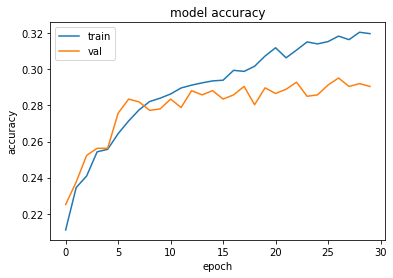

In [ ]:
train(model_lstm,'lstm')


In [ ]:
(fw,tb) = evaluate('lstm')
print_best_false_true_predicted(fw, tb)

32/32 [==============================] - 1s 11ms/step
True
Correctly Predicted :  312 / 1267
Accuracy :  24.62509865824783
*****************************************************************
******************** False statements *************************
0.34687328
id                                                                                                                                                                                                                                 9051.json
label                                                                                                                                                                                                                             pants-fire
statement      Says President Barack Obama told a room of students, Children, every time I clap my hands together, a child in America dies from gun violence, and then a child told him he could solve the problem by not clapping any more.
subject                  

**CNN**

In [ ]:
#Hyperparams for CNN
kernel_sizes = [3,3,3]
filter_size = 128

In [ ]:
kernel_stmt = []
kernel_pos = []
kernel_dep = []

use_pos=False
use_meta=True
use_dep=True

statement_input = Input(shape=(num_steps,), dtype='int32', name='main_input')
x_stmt = Embedding(vocab_length+1,EMBED_DIM,weights=[embedding_matrix],input_length=num_steps,trainable=False)(statement_input) 

# pos embed LSTM
pos_input = Input(shape=(num_steps,), dtype='int32', name='pos_input')
x_pos = Embedding(max(pos_dict.values()), max(pos_dict.values()), weights=[pos_embeddings], input_length=num_steps, trainable=False)(pos_input)

# dep embed LSTM
dep_input = Input(shape=(num_steps,), dtype='int32', name='dep_input')
x_dep = Embedding(max(dep_dict.values()), max(dep_dict.values()), weights=[dep_embeddings], input_length=num_steps, trainable=False)(dep_input)


for kernel in kernel_sizes:
    x_1 = Conv1D(filters=filter_size,kernel_size=kernel)(x_stmt)
    x_1 = GlobalMaxPool1D()(x_1)
    kernel_stmt.append(x_1)
    
    # x_2 = Conv1D(filters=filter_size,kernel_size=kernel)(x_pos)
    # x_2 = GlobalMaxPool1D()(x_2)
    # kernel_pos.append(x_2)
    
    # x_3 = Conv1D(filters=filter_size,kernel_size=kernel)(x_dep)
    # x_3 = GlobalMaxPool1D()(x_3)
    # kernel_dep.append(x_3)
    
conv_in1 = keras.layers.concatenate(kernel_stmt)
conv_in1 = Dropout(0.6)(conv_in1)
conv_in1 = Dense(128, activation='relu')(conv_in1)

# conv_in2 = keras.layers.concatenate(kernel_pos)
# conv_in2 = Dropout(0.6)(conv_in2)
# conv_in2 = Dense(128, activation='relu')(conv_in2)

# conv_in3 = keras.layers.concatenate(kernel_dep)
# conv_in3 = Dropout(0.6)(conv_in3)
# conv_in3 = Dense(128, activation='relu')(conv_in3)

# meta data
meta_input = Input(shape=(X_train_meta.shape[1],), name='aux_input')
x_meta = Dense(64, activation='relu')(meta_input)

# if use_pos and use_meta:
#   if use_dep:
#     x = keras.layers.concatenate([conv_in1, conv_in2, conv_in3, x_meta])
#   else:
#     x = keras.layers.concatenate([conv_in1, conv_in2, x_meta])
# elif use_meta:
#   if use_dep:
#     x = keras.layers.concatenate([conv_in1, conv_in3, x_meta])
#   else:
#     x = keras.layers.concatenate([conv_in1, x_meta])
# elif use_pos:
#   if use_dep:
#     x = keras.layers.concatenate([conv_in1, conv_in2, conv_in3])
#   else:
#     x = keras.layers.concatenate([conv_in1, conv_in2])
# else:
#   if use_dep:
#     x = keras.layers.concatenate([conv_in1, conv_in3])
#   else:
#     x = conv_in1

# meta and statement
x = keras.layers.concatenate([conv_in1, x_meta])

main_output = Dense(6, activation='softmax', name='main_output')(x)

# if use_pos and use_meta:
#   if use_dep:
#     model_cnn = Model(inputs=[statement_input, pos_input, dep_input, meta_input], outputs=[main_output])
#   else:
#     model_cnn = Model(inputs=[statement_input, pos_input, meta_input], outputs=[main_output])
# elif use_meta:
#   if use_dep:
#     model_cnn = Model(inputs=[statement_input, dep_input, meta_input], outputs=[main_output])
#   else:
#     model_cnn = Model(inputs=[statement_input, meta_input], outputs=[main_output])
# elif use_pos:
#   if use_dep:
#     model_cnn = Model(inputs=[statement_input, pos_input, dep_input], outputs=[main_output])
#   else:
#     model_cnn = Model(inputs=[statement_input, pos_input], outputs=[main_output])
# else:
#   if use_dep:
#     model_cnn = Model(inputs=[statement_input, dep_input], outputs=[main_output])
#   else:
#     model_cnn = Model(inputs=[statement_input], outputs=[main_output])

model_cnn = Model(inputs=[statement_input,meta_input], outputs=[main_output])

In [ ]:
train(model_cnn,'cnn')

In [ ]:
(fw, tb) = evaluate('cnn', use_pos, use_meta, use_dep)
print_best_false_true_predicted(fw, tb)